In this python file we compute the cost for a network under a Wardrop Equilibrium.
If you don't know what that is, two good places to start:
- Pau's slides on this, slide 9 ish https://classroom.google.com/c/NDkyMDU5MTg0Mjg1/m/NTk4MTEzNTU4NzM3/details
- check out the methodology section of the Networks II paper here:
    https://classroom.google.com/c/NDkyMDU5MTg0Mjg1/p/NTQzNjcyNDMwMTkx?pli=1



I use the code from [this notebook](https://nbviewer.org/github/PyTrans/Urban-Network-Analysis/blob/master/Trip_Assignment-Frank-Wolfe_Algorithm.ipynb) to solve the Wardrop Equilibrium  for a multi-source/sink traffic flow problem.

you may need to download the pytrans github repository before running this code. you can do this by running the following, according to the readme for the respository:
```
git clone https://github.com/PyTrans/Urban-Network-Analysis.git
```
I'd recommend not nesting the repositories (installing it inside of the bike-stations repository).
Just a gut feeling.

# Computing the latency costs at equilbrium using pytrans

First, we import required packages.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from itertools import combinations
from bike_functions import *
import matplotlib.pyplot as plt
from pytrans.UrbanNetworkAnalysis import TransportationNetworks as tn

Files

In [ ]:
siouxFalls.graph.

In [ ]:
nx.shortest_path(siouxFalls2.graph, station[0],station[1], weight='time')

In [77]:
siouxFalls.od_vols

{('1', '1'): 0.0,
 ('1', '2'): 100.0,
 ('1', '3'): 100.0,
 ('1', '4'): 500.0,
 ('1', '5'): 200.0,
 ('1', '6'): 300.0,
 ('1', '7'): 500.0,
 ('1', '8'): 800.0,
 ('1', '9'): 500.0,
 ('1', '10'): 1300.0,
 ('1', '11'): 500.0,
 ('1', '12'): 200.0,
 ('1', '13'): 500.0,
 ('1', '14'): 300.0,
 ('1', '15'): 500.0,
 ('1', '16'): 500.0,
 ('1', '17'): 400.0,
 ('1', '18'): 100.0,
 ('1', '19'): 300.0,
 ('1', '20'): 300.0,
 ('1', '21'): 100.0,
 ('1', '22'): 400.0,
 ('1', '23'): 300.0,
 ('1', '24'): 100.0,
 ('2', '1'): 100.0,
 ('2', '2'): 0.0,
 ('2', '3'): 100.0,
 ('2', '4'): 200.0,
 ('2', '5'): 100.0,
 ('2', '6'): 400.0,
 ('2', '7'): 200.0,
 ('2', '8'): 400.0,
 ('2', '9'): 200.0,
 ('2', '10'): 600.0,
 ('2', '11'): 200.0,
 ('2', '12'): 100.0,
 ('2', '13'): 300.0,
 ('2', '14'): 100.0,
 ('2', '15'): 100.0,
 ('2', '16'): 400.0,
 ('2', '17'): 200.0,
 ('2', '18'): 0.0,
 ('2', '19'): 100.0,
 ('2', '20'): 100.0,
 ('2', '21'): 0.0,
 ('2', '22'): 100.0,
 ('2', '23'): 0.0,
 ('2', '24'): 0.0,
 ('3', '1'): 100.0,
 

In [2]:
link_file = 'Data/SiouxFalls_net.tntp'
trip_file = 'Data/SiouxFalls_trips.tntp'
node_file = 'Data/SiouxFalls_node.tntp'

SO = False # True - System optimum, False - User equilibrium
siouxFalls = tn.Network(link_file, trip_file, node_file, SO)

# Social Equilibrium - no stations
### Implement iterative optimization steps (UE)
#### 1. Initialization

Perform the All-or-Nothing (AoN) assignment based on the free flow travel time (t0) and calculate the link performance (t1) based on the link volume (x0) 

In [25]:
## initialization

# define output variables, network and fwResult
network = {(u,v): {'t0':d['object'].t0, 'alpha':d['object'].alpha, \
           'beta':d['object'].beta, 'capa':d['object'].capacity, 'flow':[], \
           'auxiliary':[], 'cost':[]} for (u, v, d) in siouxFalls.graph.edges(data=True)}

fwResult = {'theta':[], 'z':[]}

# initial all-or-nothing assignment and update link travel time(cost)
siouxFalls.all_or_nothing_assignment()
siouxFalls.update_linkcost()

for linkKey, linkVal in network.items():
    linkVal['cost'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['weight'])
    linkVal['auxiliary'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].vol)
    linkVal['flow'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].vol)

5. Convergence Test 

Converge to the equilibrium.

In [26]:
## iterations
iterNum=0
iteration = True
while iteration:
    iterNum += 1
    siouxFalls.all_or_nothing_assignment()
    siouxFalls.update_linkcost()
    
    # set auxiliary flow using updated link flow
    for linkKey, linkVal in network.items():
        linkVal['auxiliary'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].vol)
        
    # getting optimal move size (theta)
    theta = lineSearch(network, SO)
    fwResult['theta'].append(theta)
    
    # set link flow (move) based on the theta, auxiliary flow, and link flow of previous iteration
    for linkKey, linkVal in network.items():
        aux = linkVal['auxiliary'][-1]
        flow = linkVal['flow'][-1]
        linkVal['flow'].append(flow + theta*(aux-flow))
        
        siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].vol =  flow + theta * (aux - flow)
        siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].flow = flow + theta * (aux - flow)
        
    # update link travel time
    siouxFalls.update_linkcost()
    
    # calculate objective function value
    z=0
    for linkKey, linkVal in network.items():
        linkVal['cost'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['weight'])
        totalcost = siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].get_objective_function()
        z+=totalcost
        
    fwResult['z'].append(z)        
        
    # convergence test
    if iterNum == 1:
        iteration = True
    else:
        if abs(fwResult['z'][-2] - fwResult['z'][-1]) <= 0.001 or iterNum==3000:
            iteration = False

print('the cost from the last iteration, the equilibrium cost:', fwResult['z'][-1])

the cost from the last iteration, the equilibrium cost: 4231493.723668799


### Results
#### 1.Link Flow
Display the flows for each edge at social equilibrium

In [5]:
for (u, v, d) in siouxFalls.graph.edges(data=True):
    print(u, ' -> ', v, ': ', d['object'].vol)

1  ->  2 :  4378.938524088555
1  ->  3 :  7228.615486417866
2  ->  1 :  4130.003325106148
2  ->  6 :  6049.250523498256
3  ->  1 :  7477.550685400232
3  ->  4 :  13300.604875941744
3  ->  12 :  8960.740582165752
6  ->  2 :  5800.315324515856
6  ->  5 :  9399.08391649252
6  ->  8 :  13196.448939564198
4  ->  3 :  13439.26884592911
4  ->  5 :  16911.563604310515
4  ->  11 :  10401.141732437736
12  ->  3 :  9071.011811160764
12  ->  11 :  10492.327546998426
12  ->  13 :  13158.369014911897
5  ->  4 :  17409.154353020764
5  ->  6 :  8872.892316026935
5  ->  9 :  13659.114507848975
11  ->  4 :  10142.214953714789
11  ->  10 :  19638.695934389212
11  ->  12 :  10503.54707120467
11  ->  14 :  14141.366469045748
9  ->  5 :  13630.513656093734
9  ->  8 :  8237.156047099154
9  ->  10 :  22644.88024208676
8  ->  6 :  13473.705341047385
8  ->  7 :  13264.433259981031
8  ->  9 :  8203.384454934327
8  ->  16 :  11803.196803464118
7  ->  8 :  13080.188694423949
7  ->  18 :  15117.079402840387
18  -> 

# Social Equilibrium: 1 Random station

In [3]:
siouxFalls2 = siouxFalls
station = pd.Series(filter_stations(list(combinations(np.array(siouxFalls2.graph.nodes),2)))).sample(1).values[0]
all_costs = []

# if len(g_copy.get_all_shortest_paths(station[0], station[1], weights='free_flow_time')) == 0:
#     exit()
# print('station 1: ', station[0], 'station 2:', station[1])

# get the shortest path between two nodes
shortest_path = nx.shortest_path(siouxFalls2.graph, station[0],station[1], weight='time')

# Calculate time, length and capacity
bike_edge_time = calculate_path_free_flow_time(shortest_path, siouxFalls2.graph) * 1/2
path_length = calculate_path_length(shortest_path, siouxFalls2.graph)
capacity = calculate_path_capacity(shortest_path, siouxFalls2.graph, path_length)


# If not an edge yet then add one:    
siouxFalls2.graph = add_or_modify_undirected_edge(siouxFalls2.graph, station[0], station[1], bike_edge_time, path_length, capacity)

node_colors = ['red' if node in station else 'blue' for node in siouxFalls2.graph.nodes()]

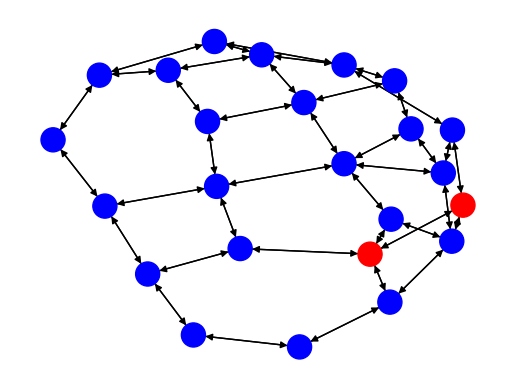

What happens if we add a path from 5 to 7, where the previous shortest path was ['5', '6', '8', '7']?


In [4]:
node_colors = ['red' if node in station else 'blue' for node in siouxFalls2.graph.nodes()]

fig, ax = plt.subplots()

pos = nx.spring_layout(siouxFalls2.graph)
nx.draw_networkx_nodes(siouxFalls2.graph, pos, node_color=node_colors)
nx.draw_networkx_edges(siouxFalls2.graph, pos, edgelist=siouxFalls2.graph.edges())
plt.axis('off')

plt.show()
print('What happens if we add a path from {} to {}, where the previous shortest path was {}?'.format(station[0], station[1], shortest_path))

In [5]:
# initialization

# define output variables, network and fwResult
network = {(u,v): {'t0':d['object'].t0, 'alpha':d['object'].alpha, \
           'beta':d['object'].beta, 'capa':d['object'].capacity, 'flow':[], \
           'auxiliary':[], 'cost':[]} for (u, v, d) in siouxFalls2.graph.edges(data=True)}

fwResult = {'theta':[], 'z':[]}

# initial all-or-nothing assignment and update link travel time(cost)
siouxFalls2.all_or_nothing_assignment()
siouxFalls2.update_linkcost()

for linkKey, linkVal in network.items():
    linkVal['cost'].append(siouxFalls2.graph[linkKey[0]][linkKey[1]]['weight'])
    linkVal['auxiliary'].append(siouxFalls2.graph[linkKey[0]][linkKey[1]]['object'].vol)
    linkVal['flow'].append(siouxFalls2.graph[linkKey[0]][linkKey[1]]['object'].vol)

In [6]:
## iterations
iterNum = 0
iteration = True
while iteration:
    iterNum += 1
    siouxFalls2.all_or_nothing_assignment()
    siouxFalls2.update_linkcost()
    
    # set auxiliary flow using updated link flow
    for linkKey, linkVal in network.items():
        linkVal['auxiliary'].append(siouxFalls2.graph[linkKey[0]][linkKey[1]]['object'].vol)
        
    # getting optimal move size (theta)
    theta = lineSearch(network, SO)
    fwResult['theta'].append(theta)
    
    # set link flow (move) based on the theta, auxiliary flow, and link flow of previous iteration
    for linkKey, linkVal in network.items():
        aux = linkVal['auxiliary'][-1]
        flow = linkVal['flow'][-1]
        linkVal['flow'].append(flow + theta*(aux-flow))
        
        siouxFalls2.graph[linkKey[0]][linkKey[1]]['object'].vol =  flow + theta * (aux - flow)
        siouxFalls2.graph[linkKey[0]][linkKey[1]]['object'].flow = flow + theta * (aux - flow)
        
    # update link travel time
    siouxFalls2.update_linkcost()
    
    # calculate objective function value
    z=0
    for linkKey, linkVal in network.items():
        linkVal['cost'].append(siouxFalls2.graph[linkKey[0]][linkKey[1]]['weight'])
        totalcost = siouxFalls2.graph[linkKey[0]][linkKey[1]]['object'].get_objective_function()
        z += totalcost
        
    fwResult['z'].append(z)        
        
    # convergence test
    if iterNum == 1:
        iteration = True
    else:
        if abs(fwResult['z'][-2] - fwResult['z'][-1]) <= 0.001 or iterNum==3000:
            iteration = False

In [7]:
print('the cost from the last iteration, the equilibrium cost:', fwResult['z'][-1])

the cost from the last iteration, the equilibrium cost: 3837733.645039034


In [8]:
for (u, v, d) in siouxFalls2.graph.edges(data=True):
    print(u, ' -> ', v, ': ', d['object'].vol)

1  ->  2 :  2803.5526555695724
1  ->  3 :  7995.96664765392
2  ->  1 :  2835.3048231535818
2  ->  6 :  4604.075926886986
3  ->  1 :  7964.214480069909
3  ->  4 :  17660.61174826328
3  ->  12 :  11618.412619773035
6  ->  2 :  4635.828094471004
6  ->  5 :  7074.435555897129
6  ->  8 :  9462.508654274014
4  ->  3 :  17649.8984460409
4  ->  5 :  23362.387553470435
4  ->  11 :  6601.36537368627
12  ->  3 :  11597.373754411467
12  ->  11 :  8216.714208039064
12  ->  13 :  12831.789475219883
5  ->  4 :  23451.52315826434
5  ->  6 :  7071.511603589964
5  ->  9 :  12459.28884063951
5  ->  7 :  12810.93520382071
11  ->  4 :  6601.516466669927
11  ->  10 :  16095.581696789164
11  ->  12 :  8212.999845991717
11  ->  14 :  8765.541950707393
9  ->  5 :  12503.452189409369
9  ->  8 :  5047.766516777317
9  ->  10 :  19347.110482669
8  ->  6 :  9497.184774165198
8  ->  7 :  9568.889313832617
8  ->  9 :  5080.160805304605
8  ->  16 :  7108.412991459349
7  ->  8 :  9621.82306488247
7  ->  18 :  20598.191

# Testing all station possibilities

First, let's generate all possible combinations of bike station placement for the graph. By using set(), we omit pairs like ('2','1'), since for our purposes it is equivalent to ('1','2')

In [3]:
stations2 = list(set(combinations(np.array(siouxFalls.graph.nodes),2)))
stations3 = list(set(combinations(np.array(siouxFalls.graph.nodes),3)))

### Doing this in parallel

In [4]:
station_graph_tuples = [(station, siouxFalls) for station in stations2]

In [8]:
import multiprocessing as mp

# Step 3: Define the number of processes to use
num_processes = mp.cpu_count()

# Step 4: Create a multiprocessing pool object with the desired number of processes
pool = mp.Pool(num_processes)

# Step 5: Map the function to the input data using the multiprocessing pool
all_costs = pool.starmap(compute_eq_cost, station_graph_tuples)

# Step 6: Close the pool to free up resources
pool.close()

station ('2', '24') eq cost computed. Cost: 4095900.453494366
station ('1', '13') eq cost computed. Cost: 4164281.0704031494
station ('11', '10') eq cost computed. Cost: 4062216.9233378973
station ('7', '16') eq cost computed. Cost: 4193726.8837008774
station ('9', '24') eq cost computed. Cost: 3928446.758866408
station ('18', '15') eq cost computed. Cost: 4050151.77343785
station ('11', '8') eq cost computed. Cost: 3915335.623831422
station ('13', '21') eq cost computed. Cost: 3910467.150272059
station ('19', '20') eq cost computed. Cost: 4008185.0786874364
station ('1', '16') eq cost computed. Cost: 3592378.149597182
station ('5', '13') eq cost computed. Cost: 3856886.156857726
station ('17', '21') eq cost computed. Cost: 4021695.296806591
station ('16', '21') eq cost computed. Cost: 3779482.3714988846
station ('23', '22') eq cost computed. Cost: 3855047.1617674343
station ('8', '23') eq cost computed. Cost: 3832738.2853595167
station ('4', '21') eq cost computed. Cost: 3573706.56415

In [9]:
station_cost_df = pd.DataFrame({'stations':stations2, 'cost':all_costs})

<Axes: >

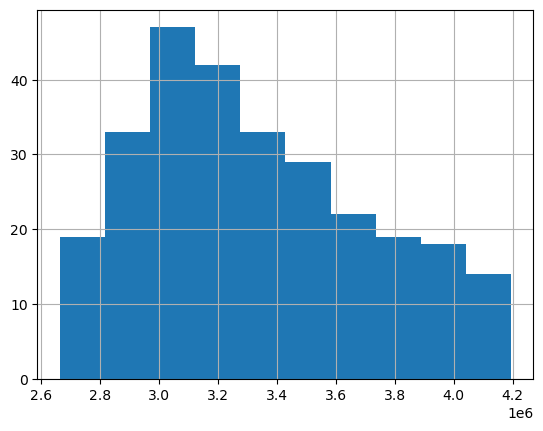

In [10]:
station_cost_df.cost.hist()

In [177]:
# compute degree centrality for all nodes
out_degree_centrality = nx.out_degree_centrality(siouxFalls.graph)
in_degree_centrality = nx.in_degree_centrality(siouxFalls.graph)

# compute betweenness centrality for all nodes
betweenness_centrality = nx.betweenness_centrality(siouxFalls.graph)

# compute eigenvector centrality for all nodes
eigenvector_centrality = nx.eigenvector_centrality(siouxFalls.graph)

# closeness_centrality
closeness_centrality = nx.closeness_centrality(siouxFalls.graph)


In [186]:
centrality = pd.DataFrame([betweenness_centrality, out_degree_centrality, in_degree_centrality, eigenvector_centrality, closeness_centrality]).T.rename(columns={0:'betweenness',1:'out_degree', 2:'in_degree', 3:'eigenvector', 4:'closeness'})

In [187]:
station1 = []
station2 = []
for station in station_cost_df.stations:
    station1.append(station[0])
    station2.append(station[1])

station_cost_df['station1'] = station1
station_cost_df['station2'] = station2

In [189]:
centrality

,betweenness,out_degree,in_degree,eigenvector,closeness
1,0.035244,0.086957,0.086957,0.034586,0.264368
2,0.036797,0.086957,0.086957,0.041609,0.267442
3,0.095285,0.130435,0.130435,0.078701,0.306667
6,0.097666,0.130435,0.130435,0.110150,0.310811
4,0.100838,0.130435,0.130435,0.128455,0.348485
12,0.131799,0.130435,0.130435,0.110723,0.348485
5,0.065152,0.130435,0.130435,0.128600,0.333333
11,0.226379,0.173913,0.173913,0.239538,0.403509
9,0.075878,0.130435,0.130435,0.208734,0.365079
8,0.138553,0.173913,0.173913,0.212955,0.343284


In [190]:
station_cost_centrality = station_cost_df.merge(centrality, how='left', left_on='station1', right_index=True).merge(centrality, how='left', left_on='station2', right_index=True,  suffixes=("_o", "_d"))
station_cost_centrality['int_in_degree_centrality'] = station_cost_centrality.in_degree_o * station_cost_centrality.in_degree_d
station_cost_centrality['int_out_degree_centrality'] = station_cost_centrality.out_degree_o * station_cost_centrality.out_degree_d

In [191]:
og_cost = 4231493.723668799
station_cost_centrality['pct_change']  = (station_cost_centrality.cost - og_cost)/og_cost

In [192]:
def sum_edge_volumes(n, graph):
    volume_sum = 0
    for neighbor in graph.neighbors(n):
        volume_sum += graph[n][neighbor]['object'].vol
    return volume_sum

In [193]:
import networkx as nx

def calculate_hypothetical_travel_time_reduction(hyp_edge, graph, traffic_dict):
    # Copy the original graph
    new_graph = graph.copy()

    # Add the hypothetical edge to the new graph
    shortest_path = nx.shortest_path(graph, hyp_edge[0], hyp_edge[1], weight='time')
    edge_time = 0
    for i in range(len(shortest_path) - 1):
        edge_time += new_graph[shortest_path[i]][shortest_path[i+1]]['time']
    new_graph.add_edge(hyp_edge[0], hyp_edge[1], time=edge_time*.5)

    # Calculate the original travel time
    orig_travel_time = 0
    for origin, dest in traffic_dict.keys():
        volume = traffic_dict[(origin, dest)]
        shortest_path = nx.shortest_path(graph, origin, dest, weight='time')
        edge_time = 0
        for i in range(len(shortest_path) - 1):
            edge_time += graph[shortest_path[i]][shortest_path[i+1]]['time']
        orig_travel_time += edge_time * volume

    # Calculate the hypothetical travel time
    hyp_travel_time = 0
    for origin, dest in traffic_dict.keys():
        volume = traffic_dict[(origin, dest)]
        shortest_path = nx.shortest_path(new_graph, origin, dest, weight='time')
        edge_time = 0
        for i in range(len(shortest_path) - 1):
            edge_time += new_graph[shortest_path[i]][shortest_path[i+1]]['time']
        hyp_travel_time += edge_time * volume

    # Calculate the travel time reduction
    travel_time_reduction = orig_travel_time - hyp_travel_time

    return travel_time_reduction


In [194]:
station_cost_centrality['volume_x'] = station_cost_centrality.station1.apply(sum_edge_volumes, graph=siouxFalls.graph)
station_cost_centrality['volume_y'] = station_cost_centrality.station2.apply(sum_edge_volumes, graph=siouxFalls.graph)
station_cost_centrality['hyp_time_reduction'] = station_cost_centrality.stations.apply( calculate_hypothetical_travel_time_reduction, graph= siouxFalls.graph, traffic_dict= siouxFalls.od_vols)

In [195]:
station_cost_centrality['hyp_time_reduction'] = np.log((station_cost_centrality.hyp_time_reduction / np.linalg.norm(station_cost_centrality.hyp_time_reduction)))

<Axes: xlabel='hyp_time_reduction', ylabel='pct_change'>

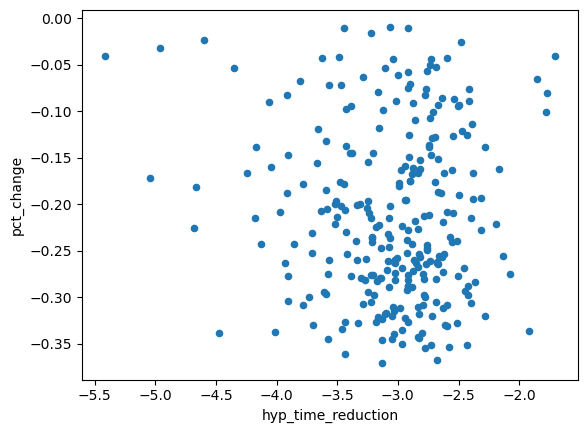

In [206]:
station_cost_centrality[['hyp_time_reduction', 'pct_change']].plot.scatter(x='hyp_time_reduction',y='pct_change')

In [172]:
import statsmodels.api as sm
import pandas as pd

# create a sample data frame with two variables
# add a constant column for the intercept term

# fit a linear model using ordinary least squares (OLS)
betweenness_model = sm.OLS(station_cost_centrality['pct_change'], station_cost_centrality[['const', 'betweenness_x', 'betweenness_y']]).fit()
degree_model = sm.OLS(station_cost_centrality['pct_change'], station_cost_centrality[['const', 'degree_x', 'degree_y']]).fit()
eigen_model = sm.OLS(station_cost_centrality['pct_change'], station_cost_centrality[['const', 'eigenvector_x', 'eigenvector_y']]).fit()
closeness_model = sm.OLS(station_cost_centrality['pct_change'], station_cost_centrality[['const', 'closeness_x', 'closeness_y']]).fit()
volume_model = sm.OLS(station_cost_centrality['pct_change'], station_cost_centrality[['const', 'volume_x', 'volume_y']]).fit()
time_reduction_model = sm.OLS(station_cost_centrality['pct_change'], station_cost_centrality[['const', 'hyp_time_reduction']]).fit()

In [197]:
station_cost_centrality.columns

Index(['stations', 'cost', 'station1', 'station2', 'betweenness_o',
       'out_degree_o', 'in_degree_o', 'eigenvector_o', 'closeness_o',
       'betweenness_d', 'out_degree_d', 'in_degree_d', 'eigenvector_d',
       'closeness_d', 'int_in_degree_centrality', 'int_out_degree_centrality',
       'pct_change', 'volume_x', 'volume_y', 'hyp_time_reduction'],
      dtype='object')

In [202]:
station_cost_centrality = sm.add_constant(station_cost_centrality)

big_model = sm.OLS(station_cost_centrality['pct_change'], station_cost_centrality[['const', 'betweenness_o',
       'out_degree_o', 'in_degree_o', 'eigenvector_o', 'closeness_o',
       'betweenness_d', 'out_degree_d', 'in_degree_d', 'eigenvector_d',
       'closeness_d', 'int_in_degree_centrality', 'int_out_degree_centrality', 'volume_x', 'volume_y', 'hyp_time_reduction']]).fit()

In [204]:
big_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             pct_change   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.235
Date:                Sun, 02 Apr 2023   Prob (F-statistic):              0.259
Time:                        22:41:15   Log-Likelihood:                 277.60
No. Observations:                 276   AIC:                            -529.2
Df Residuals:                     263   BIC:                            -482.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.2735      0.250     -1.093      0.275      -0.766       0.219
betweenness_o                -0.0858      0.265     -0.324      0.747      -0.608       0.436
out_degree_o                 -0.1994      0.508     -0.392      0.695      -1.200       0.801
in_degree_o                  -0.1994      0.508     -0.392      0.695      -1.200       0.801
eigenvector_o                 0.2384      0.198      1.204      0.230      -0.151       0.628
closeness_o                  -0.3191      0.400     -0.798      0.425      -1.106       0.468
betweenness_d                -0.3339      0.328     -1.017      0.310      -0.981       0.313
out_degree_d                  0.2845      0.502      0.567      0.571      -0.703       1.272
in_degree_d                   0.2845      0.502      0.567      0.571      -0.703       1.272
eigenvector_d                -0.4083      0.277     -1.472      0.142      -0.955       0.138
closeness_d                   0.1530      0.513      0.298      0.766      -0.858       1.164
int_in_degree_centrality      2.3513      2.809      0.837      0.403      -3.179       7.882
int_out_degree_centrality     2.3513      2.809      0.837      0.403      -3.179       7.882
volume_x                  -7.111e-08   7.44e-07     -0.096      0.924   -1.54e-06    1.39e-06
volume_y                   6.757e-07   7.13e-07      0.947      0.344   -7.29e-07    2.08e-06
hyp_time_reduction           -0.0198      0.012     -1.680      0.094      -0.043       0.003
==============================================================================
Omnibus:                       21.631   Durbin-Watson:                   1.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.622
Skew:                           0.369   Prob(JB):                      0.00182
Kurtosis:                       2.257   Cond. No.                     1.59e+24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.19e-37. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [19]:
betweenness_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cost   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                  0.001293
Date:                Sun, 02 Apr 2023   Prob (F-statistic):              0.999
Time:                        20:49:35   Log-Likelihood:                -3941.2
No. Observations:                 276   AIC:                             7888.
Df Residuals:                     273   BIC:                             7899.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           3.33e+06   6.18e+04     53.854      0.000    3.21e+06    3.45e+06
betweenness_x -2970.2649    4.2e+05     -0.007      0.994   -8.29e+05    8.23e+05
betweenness_y  2.256e+04   4.51e+05      0.050      0.960   -8.65e+05     9.1e+05
==============================================================================
Omnibus:                       29.650   Durbin-Watson:                   1.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.915
Skew:                           0.423   Prob(JB):                     0.000350
Kurtosis:                       2.184   Cond. No.                         19.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='avg_betweenness_centrality', ylabel='cost'>

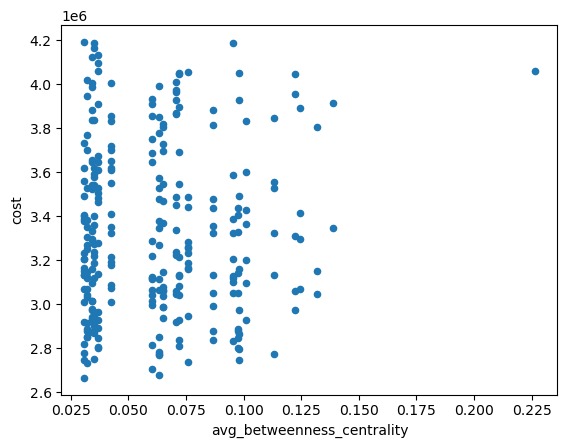

In [17]:
pd.concat([station_cost_centrality[['betweenness_x', 'betweenness_y']].min(axis=1), station_cost_centrality.cost], axis=1).rename({0:'avg_betweenness_centrality'}, axis=1).plot.scatter(x='avg_betweenness_centrality', y= 'cost')

In [21]:
low_4 = np.argsort(station_cost_centrality.cost)[0:4].values
top_4 = np.argsort(station_cost_centrality.cost)[-4:]

In [138]:
station_cost_centrality.to_csv('station_cost_centrality.csv')

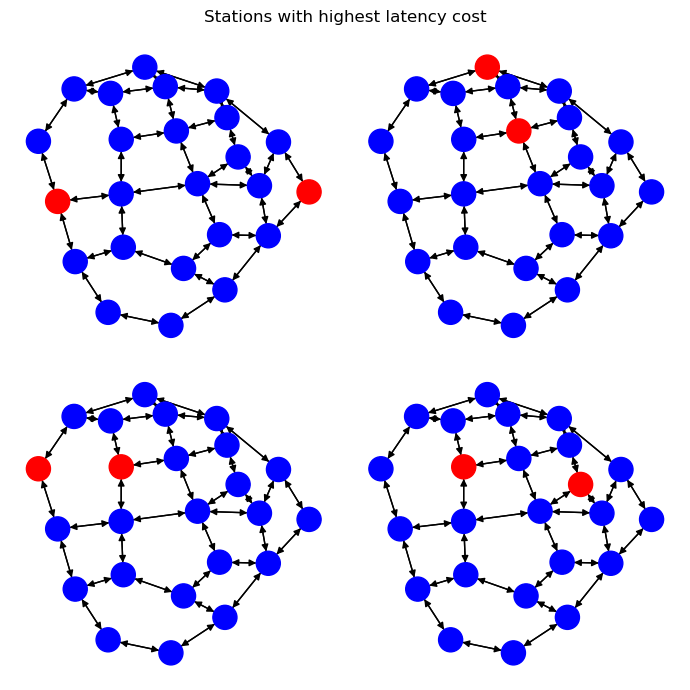

In [22]:
import matplotlib.pyplot as plt
import networkx as nx

# create four color sets
node_colors1 = ['red' if node in station_cost_centrality.loc[low_4].iloc[0].stations else 'blue' for node in siouxFalls.graph.nodes()]
node_colors2 = ['red' if node in station_cost_centrality.loc[low_4].iloc[1].stations else 'blue' for node in siouxFalls.graph.nodes()]
node_colors3 = ['red' if node in station_cost_centrality.loc[low_4].iloc[2].stations else 'blue' for node in siouxFalls.graph.nodes()]
node_colors4 = ['red' if node in station_cost_centrality.loc[low_4].iloc[3].stations else 'blue' for node in siouxFalls.graph.nodes()]
# create a 2x2 plot grid
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
pos = nx.spring_layout(siouxFalls.graph)


# plot each graph in a different subplot
np.random.seed(123)
nx.draw(siouxFalls.graph.copy(), ax=axs[0, 0], node_color=node_colors1)
np.random.seed(123)
nx.draw(siouxFalls.graph.copy(), ax=axs[0, 1], node_color=node_colors2)
np.random.seed(123)
nx.draw(siouxFalls.graph.copy(), ax=axs[1, 0], node_color=node_colors3)
np.random.seed(123)
nx.draw(siouxFalls.graph.copy(), ax=axs[1, 1], node_color=node_colors4)

# set plot title and axis labels
fig.suptitle('Stations with highest latency cost')
plt.tight_layout()
plt.show()

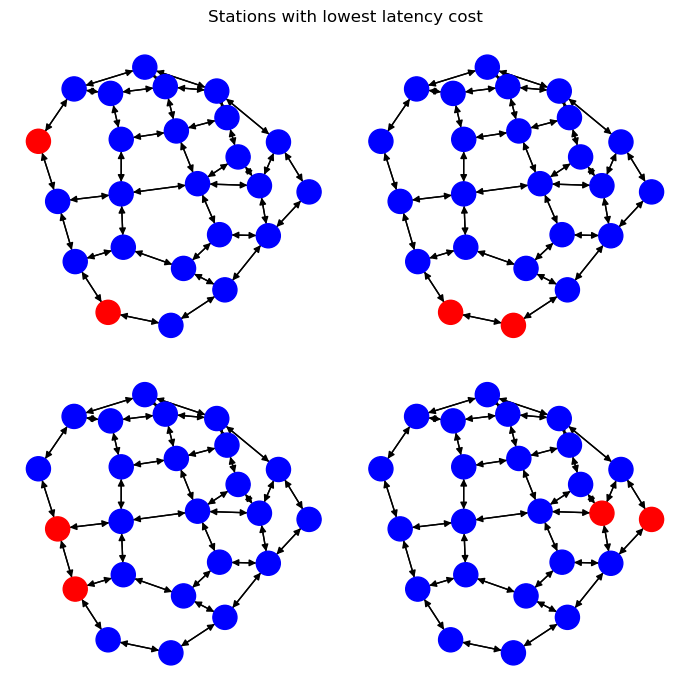

In [23]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.pyplot import figure

# create four color sets
node_colors1 = ['red' if node in station_cost_centrality.loc[top_4].iloc[0].stations else 'blue' for node in siouxFalls.graph.nodes()]
node_colors2 = ['red' if node in station_cost_centrality.loc[top_4].iloc[1].stations else 'blue' for node in siouxFalls.graph.nodes()]
node_colors3 = ['red' if node in station_cost_centrality.loc[top_4].iloc[2].stations else 'blue' for node in siouxFalls.graph.nodes()]
node_colors4 = ['red' if node in station_cost_centrality.loc[top_4].iloc[3].stations else 'blue' for node in siouxFalls.graph.nodes()]
# create a 2x2 plot grid
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
pos = nx.spring_layout(siouxFalls.graph)


# plot each graph in a different subplot
np.random.seed(123)
nx.draw(siouxFalls.graph.copy(), ax=axs[0, 0], node_color=node_colors1)
np.random.seed(123)
nx.draw(siouxFalls.graph.copy(), ax=axs[0, 1], node_color=node_colors2)
np.random.seed(123)
nx.draw(siouxFalls.graph.copy(), ax=axs[1, 0], node_color=node_colors3)
np.random.seed(123)
nx.draw(siouxFalls.graph.copy(), ax=axs[1, 1], node_color=node_colors4)

# set plot title and axis labels
fig.suptitle('Stations with lowest latency cost')


plt.tight_layout()
plt.show()

In [120]:
station_cost_centrality.sort_values(by='cost')

,const,stations,cost,station1,station2,betweenness_x,degree_x,eigenvector_x,betweenness_y,degree_y,eigenvector_y
107,1.0,"(10, 13)",2.582308e+06,10,13,0.239977,0.434783,0.384541,0.060277,0.173913,0.066920
44,1.0,"(9, 7)",2.691678e+06,9,7,0.075878,0.260870,0.208734,0.030665,0.173913,0.117212
251,1.0,"(8, 22)",2.749620e+06,8,22,0.138553,0.347826,0.212955,0.071888,0.347826,0.267482
61,1.0,"(10, 15)",2.771932e+06,10,15,0.239977,0.434783,0.384541,0.122476,0.347826,0.317121
269,1.0,"(4, 11)",2.800767e+06,4,11,0.100838,0.260870,0.128455,0.226379,0.347826,0.239538
...,...,...,...,...,...,...,...,...,...,...,...
126,1.0,"(3, 7)",5.943854e+06,3,7,0.095285,0.260870,0.078701,0.030665,0.173913,0.117212
243,1.0,"(10, 23)",6.113965e+06,10,23,0.239977,0.434783,0.384541,0.042478,0.260870,0.172218
216,1.0,"(8, 13)",6.780589e+06,8,13,0.138553,0.347826,0.212955,0.060277,0.173913,0.066920
81,1.0,"(7, 19)",9.157548e+06,7,19,0.030665,0.173913,0.117212,0.034064,0.260870,0.241578


In [152]:
centrality_dict = station_cost_centrality[['station1','closeness_x', 'betweenness_x', 'degree_x']].set_index('station1').to_dict(orient='dict')

In [153]:
def get_topsis(closeness_centr,between_centr,degr_centr):
    centralities=dict()
    for i in zip(closeness_centr,closeness_centr.values(),between_centr.values(),degr_centr.values()):
        centralities[i[0]]=i[1],i[2],i[3]
    centrdf=pd.DataFrame.from_dict(centralities)
    centrdf=centrdf.T
    centrdf.columns=['cc','bc','dc']    
    wv=np.array([0.1180,0.2689,0.6131])
    wv=wv.reshape(-1,1)
    centrmatrix=centrdf.copy().to_numpy()
    centrmatrix[:,0]=(centrmatrix[:,0]*wv[0])/(np.sqrt(np.sum(np.square(centrmatrix[:,0]))))
    centrmatrix[:,1]=(centrmatrix[:,1]*wv[1])/(np.sqrt(np.sum(np.square(centrmatrix[:,1]))))
    centrmatrix[:,2]=(centrmatrix[:,2]*wv[2])/(np.sqrt(np.sum(np.square(centrmatrix[:,2]))))
    nis=np.array([centrmatrix[:,0].min(),centrmatrix[:,1].min(),centrmatrix[:,2].min()])
    pis=np.array([centrmatrix[:,0].max(),centrmatrix[:,1].max(),centrmatrix[:,2].max()])
    centrdf['s+']=np.sum(np.square(centrmatrix-pis),axis=1)
    centrdf['s-']=np.sum(np.square(centrmatrix-nis),axis=1)
    # np.sum(np.square(centrmatrix-pis),axis=1)/(np.sum(np.square(centrmatrix-pis),axis=1)+np.sum(np.square(centrmatrix-nis),axis=1))
    centrdf['topsis']=np.sum(np.square(centrmatrix-pis),axis=1)/(np.sum(np.square(centrmatrix-pis),axis=1)+np.sum(np.square(centrmatrix-nis),axis=1))
    return centrdf

In [157]:
topsis = get_topsis(centrality_dict['closeness_x'], centrality_dict['betweenness_x'], centrality_dict['degree_x']).sort_values(by='topsis', ascending=False)
station_cost_topsis = station_cost_centrality.merge(topsis[['topsis']], how='left', left_on='station1', right_index=True).merge(topsis[['topsis']], how='left', left_on='station2', right_index=True)

<Axes: xlabel='avg_topsis', ylabel='cost'>

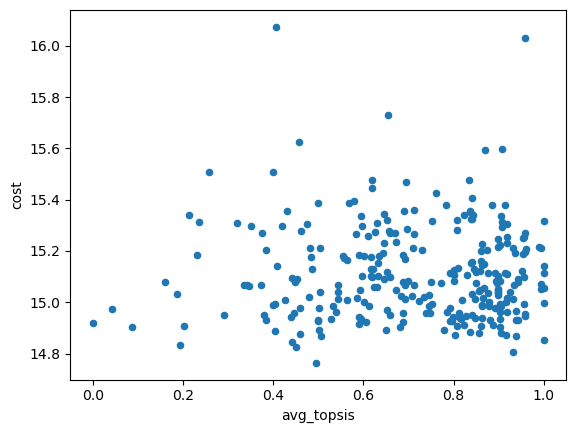

In [169]:
pd.concat([station_cost_topsis[['topsis_x', 'topsis_y']].mean(axis=1), np.log(station_cost_centrality.cost)], axis=1).rename({0:'avg_topsis'}, axis=1).plot.scatter(x='avg_topsis', y= 'cost')

<Axes: >

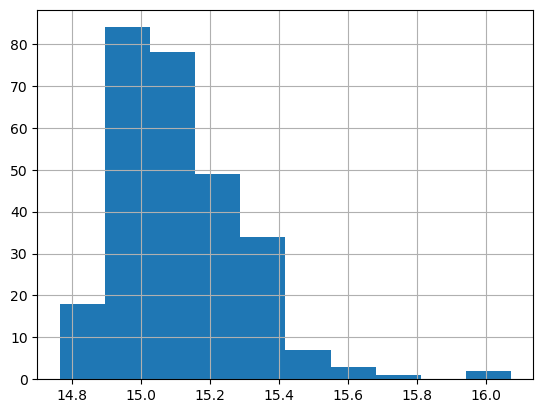

In [177]:
np.log(station_cost_centrality.cost).hist()